link to data https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
or https://drive.google.com/drive/folders/1i3XnD-JdcPHqGQjHSBw6uaq4V_IzuRNt?usp=sharing


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
#import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
#from apex import amp
import sys

In [4]:
from collections import defaultdict
import re

In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Lung Segmentation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
lung_image_paths = glob(os.path.join(data_dir, "CXR_png/*.png"))
mask_image_paths = glob(os.path.join(data_dir, "masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

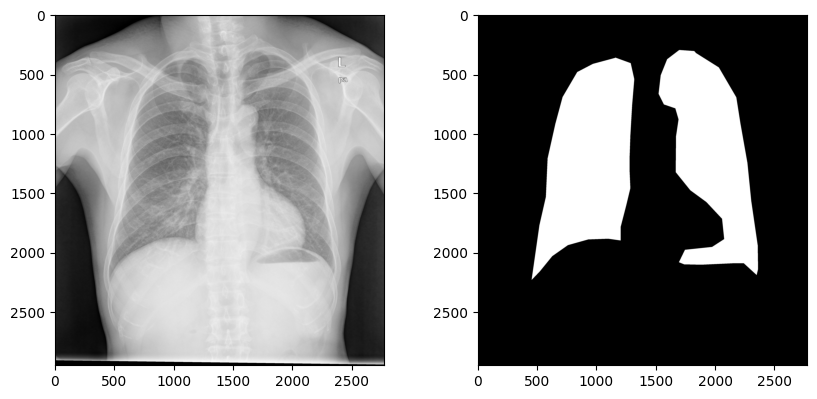

In [7]:
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [8]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (224,224), color_mode = "gray")

100%|██████████| 704/704 [00:56<00:00, 12.42it/s]


In [9]:
704/100*80

563.2

In [10]:
X_train, X_test = img_array[:563], img_array[563:]
y_train, y_test = mask_array[:563], mask_array[563:]

In [11]:
len(X_train) + len(X_test)

704

In [12]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets, transform):
        self.data = data
        self.targets = targets
        self.transforms = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transforms:
            x = self.transforms(x)
        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline

In [13]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:

dataset = MyDataset(X_train,y_train, get_transform(True))
train_loader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, get_transform(True))
val_loader = DataLoader(testset, batch_size=4)

In [15]:
import tqdm
for img,target in tqdm.tqdm(train_loader):
    z = 1

100%|██████████| 141/141 [00:00<00:00, 519.80it/s]


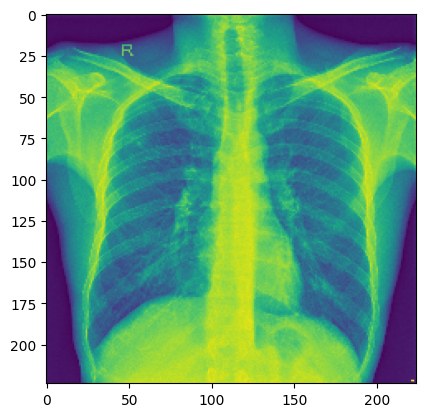

In [16]:
plt.imshow(img[0][0])

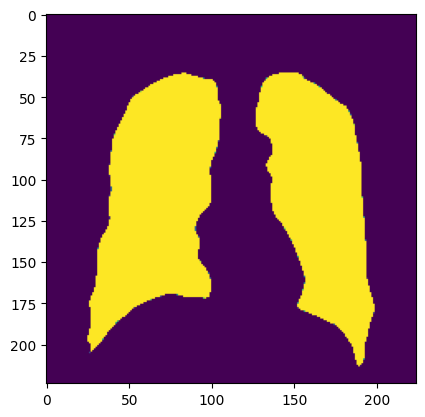

In [17]:
plt.imshow(target[0])

In [19]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [20]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).cuda()

In [ ]:
torch.cuda.is_available()

True

In [21]:
def dice_loss(pred, target):
    # Apply sigmoid activation
    pred = torch.sigmoid(pred)
    # Flatten the tensors to 1D
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    # Compute intersection
    intersection = (iflat * tflat).sum()
    # Compute sum of squares
    pred_sum = torch.sum(iflat * iflat)
    target_sum = torch.sum(tflat * tflat)
    return 1 - ((2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5))

In [22]:
criterion = dice_loss
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [23]:
losses = []
vlosses = []

In [24]:
iter_num = 0
n_epoch = 50
start_time = time.time()

for epoch_num in range(n_epoch):
    loss_ = []
    vloss_ = []
    for i_batch, sampled_batch in enumerate(train_loader):
        image_batch, label_batch = sampled_batch
        image_batch = image_batch.float()
        image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        outputs = model(image_batch)
        outputs = torch.squeeze(outputs, 1)
        loss = criterion(outputs, label_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    losses.append(np.mean(loss_,axis = 0))
    print('train epoch ',epoch_num)
    print('-------- train dice ce total', np.mean(loss_,axis = 0))
    with torch.no_grad():
        for i_batch, sampled_batch1 in enumerate(val_loader):
            image_batch1, label_batch1 = sampled_batch1
            image_batch1 = image_batch1.float()
            image_batch1, label_batch1 = image_batch1.cuda(), label_batch1.cuda()
            outputs1 = model(image_batch1)
            outputs1 = torch.squeeze(outputs1, 1)
            vloss = criterion(outputs1, label_batch1.float())
            vloss_.append(vloss.item())
        vlosses.append(np.mean(vloss_,axis = 0))
        print('-------- test loss ', np.mean(vloss_,axis = 0))
end_time = time.time()

train epoch  0
-------- train dice ce total 0.10512438606708607
-------- test loss  0.044668957591056824
train epoch  1
-------- train dice ce total 0.03677240711577395
-------- test loss  0.037619163592656456
train epoch  2
-------- train dice ce total 0.030390978704953026
-------- test loss  0.039893062578307256
train epoch  3
-------- train dice ce total 0.026097949937725743
-------- test loss  0.04219867123497857
train epoch  4
-------- train dice ce total 0.02388731469499304
-------- test loss  0.04211155904663934
train epoch  5
-------- train dice ce total 0.02250460741367746
-------- test loss  0.040984592503971524
train epoch  6
-------- train dice ce total 0.02087077519572373
-------- test loss  0.04168090224266052
train epoch  7
-------- train dice ce total 0.01887366661788724
-------- test loss  0.04097484383318159
train epoch  8
-------- train dice ce total 0.017629048080309063
-------- test loss  0.040816038846969604
train epoch  9
-------- train dice ce total 0.0172607091

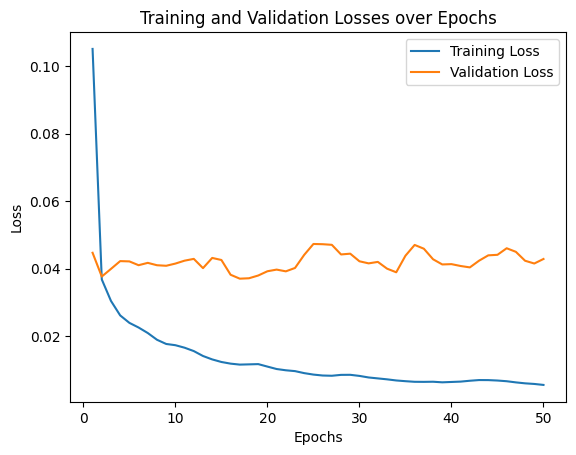

In [25]:
# Create a range of epochs for x-axis
epochs = range(1, len(losses) + 1)

# Plot training and validation losses on the same graph
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, vlosses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [26]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [27]:
d = []

In [28]:
def one_mask(img):
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Ensure channel dimension exists
    if img_tensor.shape[1] != 1:
        img_tensor = img_tensor.unsqueeze(1)   # [1, 1, H, W]

    img_tensor = img_tensor.cuda()
    with torch.no_grad():
        outputs = model(img_tensor)
        outputs = torch.sigmoid(outputs)
    try:
        mask_pred = (outputs.cpu().detach().numpy())
    except:
        mask_pred = np.zeros([512,512])
    return img_tensor.cpu().detach().numpy(), mask_pred

In [29]:
img, mask = one_mask(X_test[0])

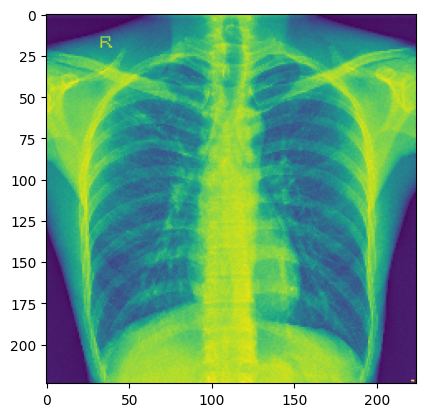

In [30]:
plt.imshow(img[0][0])

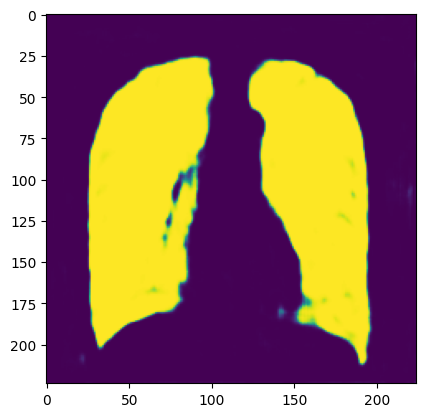

In [31]:
plt.imshow(mask[0][0])

In [32]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [36]:
import numpy as np

def calculate_dice_coefficient(mask_true, mask_pred):
    mask_true = np.squeeze(mask_true) # Remove single dimensions if any
    mask_pred = np.squeeze(mask_pred)
    mask_true_bin = (mask_true > 0.5).astype(np.float32) # Convert to binary
    mask_pred_bin = (mask_pred > 0.5).astype(np.float32)
    intersection = np.sum(mask_true_bin * mask_pred_bin)
    dice_coefficient = (2. * intersection + 1e-5) / (np.sum(mask_true_bin) + np.sum(mask_pred_bin) + 1e-5)
    return dice_coefficient

def precision_score(groundtruth_mask, pred_mask):
    # Precision = TP / (TP + FP)
    groundtruth_mask = np.squeeze(groundtruth_mask)
    pred_mask = np.squeeze(pred_mask)
    groundtruth_bin = (groundtruth_mask > 0.5).astype(np.float32)
    pred_bin = (pred_mask > 0.5).astype(np.float32)
    TP = np.sum(groundtruth_bin * pred_bin)
    FP = np.sum(pred_bin) - TP
    precision = TP / (TP + FP + 1e-5)
    return round(precision, 3)

def recall_score(groundtruth_mask, pred_mask):
    # Recall = TP / (TP + FN)
    groundtruth_mask = np.squeeze(groundtruth_mask)
    pred_mask = np.squeeze(pred_mask)
    groundtruth_bin = (groundtruth_mask > 0.5).astype(np.float32)
    pred_bin = (pred_mask > 0.5).astype(np.float32)
    TP = np.sum(groundtruth_bin * pred_bin)
    FN = np.sum(groundtruth_bin) - TP
    recall = TP / (TP + FN + 1e-5)
    return round(recall, 3)

def calculate_iou(mask_true, mask_pred):
    # Intersection over Union (IoU) = |A ∩ B| / |A ∪ B|
    mask_true = np.squeeze(mask_true)
    mask_pred = np.squeeze(mask_pred)

    mask_true_bin = (mask_true > 0.5).astype(np.float32)
    mask_pred_bin = (mask_pred > 0.5).astype(np.float32)

    intersection = np.sum(mask_true_bin * mask_pred_bin)
    union = np.sum(mask_true_bin) + np.sum(mask_pred_bin) - intersection  # Union = |A| + |B| - |A ∩ B|

    iou = intersection / (union + 1e-5)  # Add small value to prevent division by zero
    return iou

from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(mask1, mask2):
    mask1 = np.squeeze(mask1)
    mask2 = np.squeeze(mask2)
    mask1_bin = (mask1 > 0.5).astype(np.uint8)
    mask2_bin = (mask2 > 0.5).astype(np.uint8)
    # Get coordinates of non-zero (foreground) pixels
    coords1 = np.column_stack(np.where(mask1_bin))
    coords2 = np.column_stack(np.where(mask2_bin))
    # If one of the masks is empty, return NaN
    if len(coords1) == 0 or len(coords2) == 0:
         return np.nan
    # Compute directed Hausdorff distances
    hd1 = directed_hausdorff(coords1, coords2)[0]
    hd2 = directed_hausdorff(coords2, coords1)[0]
    return max(hd1, hd2)

In [34]:
dice = []
hd = []
prec = []
rec = []
iou = []
for ind,img in tqdm.tqdm(enumerate(X_test)):
    _,mask_pred = one_mask(img)
    mask_true = y_test[ind]
    dice.append(calculate_dice_coefficient(mask_true, mask_pred))
    hd.append(hausdorff_distance(mask_true, mask_pred[0][0]))
    prec.append(precision_score(mask_true, mask_pred))
    rec.append(recall_score(mask_true, mask_pred))
    iou.append(calculate_iou(mask_true, mask_pred))

141it [00:06, 23.30it/s]


In [35]:
print(np.mean(hd))
print(np.mean(dice))
print(np.mean(iou))
print(np.mean(prec))
print(np.mean(rec))


33.6507678407755
0.949681535904121
0.906063282958476
0.9646808510638296
0.9368581560283686
